In [1]:
import sys
sys.path.insert(0, "/Users/alexanderholstrup/git/VisualPlaceRecognition/cnnimageretrieval-pytorch")

In [5]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

from cirtorch.networks.imageretrievalnet import init_network, extract_vectors
from cirtorch.datasets.datahelpers import imresize, default_loader

In [17]:
network_path = '/Users/alexanderholstrup/Desktop/plots/GEN_model_epoch220.pth.tar'
multiscale = '[1]'
def load_placereg_net():
    # loading network from path
    if network_path is not None:
        state = torch.load(network_path, map_location=torch.device('cpu'))

        # parsing net params from meta
        # architecture, pooling, mean, std required
        # the rest has default values, in case that is doesnt exist
        net_params = {}
        net_params['architecture'] = state['meta']['architecture']
        net_params['pooling'] = state['meta']['pooling']
        net_params['local_whitening'] = state['meta'].get(
            'local_whitening', False)
        net_params['regional'] = state['meta'].get('regional', False)
        net_params['whitening'] = state['meta'].get('whitening', False)
        net_params['mean'] = state['meta']['mean']
        net_params['std'] = state['meta']['std']
        net_params['pretrained'] = False

        # load network
        net = init_network(net_params)
        net.load_state_dict(state['state_dict'])

        # if whitening is precomputed
        if 'Lw' in state['meta']:
            net.meta['Lw'] = state['meta']['Lw']

        print(">>>> loaded network: ")
        print(net.meta_repr())

        # setting up the multi-scale parameters
    ms = list(eval(multiscale))
    if len(ms) > 1 and net.meta['pooling'] == 'gem' and not net.meta['regional'] and not net.meta['whitening']:
        msp = net.pool.p.item()
        print(">> Set-up multiscale:")
        print(">>>> ms: {}".format(ms))
        print(">>>> msp: {}".format(msp))
    else:
        msp = 1
    return net


In [18]:
net = load_placereg_net()
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

>>>> loaded network: 
  (meta): dict( 
     architecture: resnet50
     local_whitening: False
     pooling: gem
     regional: False
     whitening: False
     outputdim: 2048
     mean: [0.485, 0.456, 0.406]
     std: [0.229, 0.224, 0.225]
  )



In [19]:
visualisation = {}

def hook_fn(m, i, o):
  visualisation[m] = o 

def get_all_layers(net):
  for name, layer in net._modules.items():
    #If it is a sequential, don't register a hook on it
    # but recursively register hook on all it's module children
    if isinstance(layer, torch.nn.Sequential):
      get_all_layers(layer)
    else:
      # it's a non sequential. Register a hook
      layer.register_forward_hook(hook_fn)

get_all_layers(net)

# Just to check whether we got all layers


In [20]:
path = '/Users/alexanderholstrup/git/VisualPlaceRecognition/cnnimageretrieval-pytorch/notebooks/data/IT5/MSEAndContrastive400/Train/Images/london/database/images/KiFXKBjFgBIOondz8Rm2Cg.jpg'
im = transform(default_loader(path)).unsqueeze_(0)
im.size()

torch.Size([1, 3, 360, 640])

In [21]:
out = net(im)
out.size()

torch.Size([2048, 1])

torch.Size([512, 45, 80])


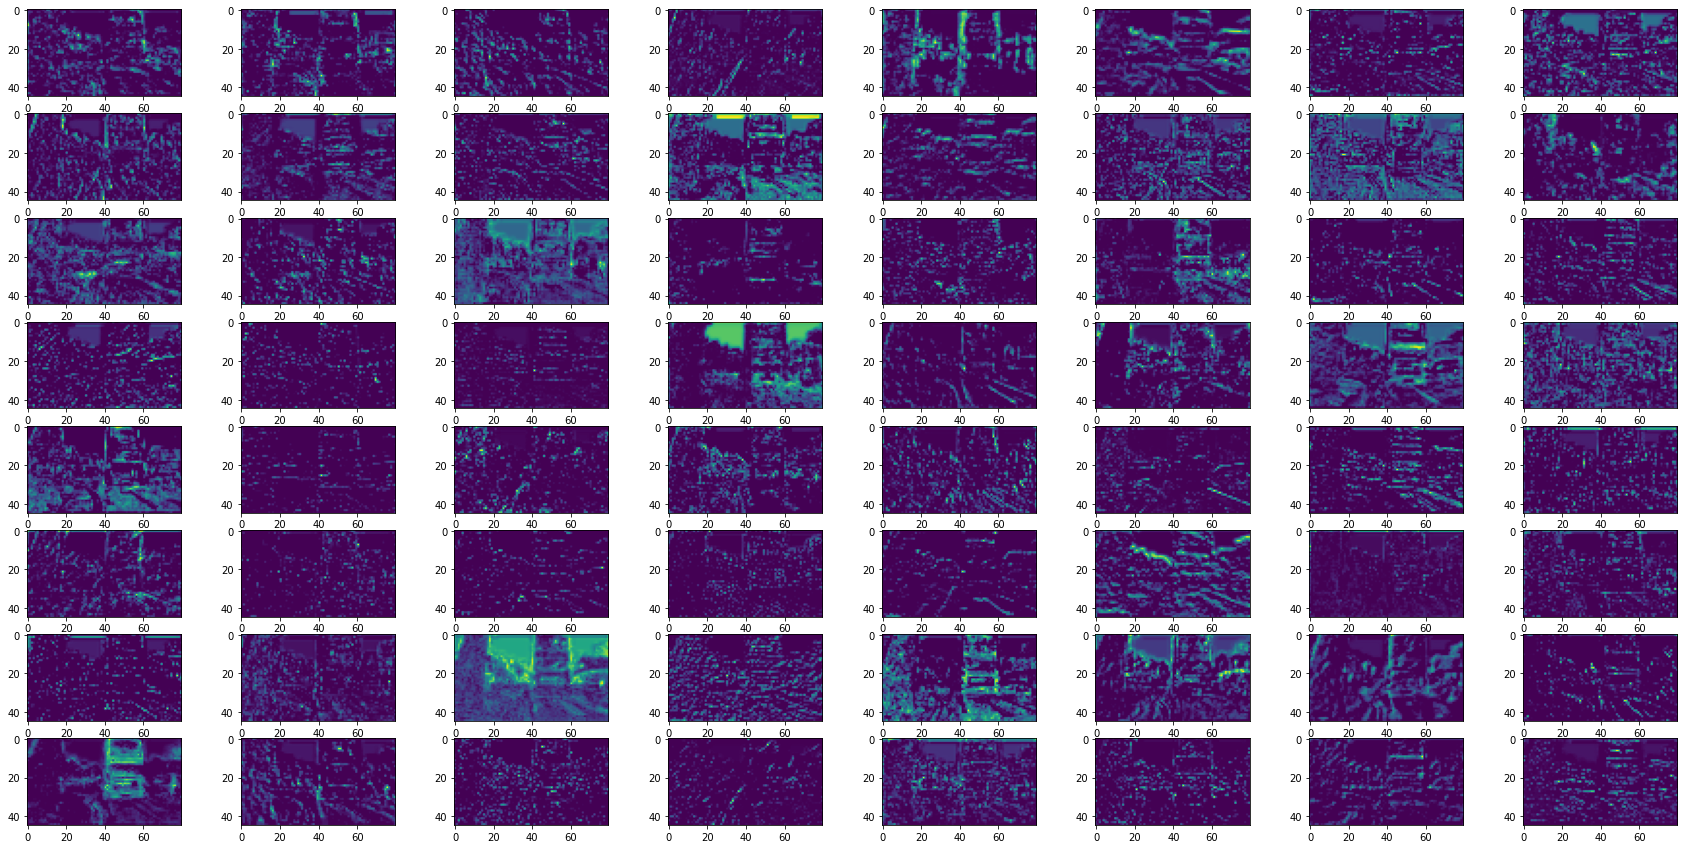

In [29]:
summed = False
for val in list(visualisation.values())[9:]:
    val = torch.squeeze(val, dim=0)
    n_activations, _, _ = val.size()
    print(val.size())
    if summed:
        att = torch.sum(val.detach(), dim=0)
        im = plt.imshow(att, cmap=plt.cm.RdBu)
        plt.colorbar(im)
    else:
        fig, axs = plt.subplots(8, 8, figsize=(30,15))
        for i in range(n_activations):
            if i < 8**2:
                axs[i // 8, i % 8].imshow(val[i,:,:].detach())
    break